# Analysis for the furniture example (online game setup)

We want to gather apply all analysis tools, we encountered/thought on the example, to get an overview and basis for analysis of the subject data. 
The ideas are:
 
 ### Analyse the feasible solution tree of each month with pruned trees/ cplex solution pool
   * are there a lot of solutions 
   *  are there many solutions close to the optimum? how do we quantify the distance

### Compare the LP and the Milp solution
   * are they close to each other
   * compare the solution pool with each other
   * Weighting of the constraints
        * can dual prices be used in MILPs
   * Analyse the cost vector, how ?
 ### Difficulty of problem
  
  * compare Erics analysis with solution pool and subject data

In [1]:
 import numpy as np
import numpy.random as npr
import os
import sys
import shutil
import matplotlib.pyplot as plt

from lp_parser import parse_lp

import matplotlib.pyplot as plt

from itertools import combinations_with_replacement, permutations, product
import pickle

import pandas as pd
import seaborn as sns
sys.path.insert(0,os.path.dirname(sys.path[0]) +'/utils')
from lp_utils import *
#from helper_solution_analysis import *


### Load the setup for the furniture example and built the MILP Model

In [2]:
resources, profit, costs = load_lp_model()



{'Bed': {'wood': 4, 'metal': 3, 'hours A': 0, 'hours B': 0, 'hours C': 3, 'hours D': 4}, 'Bookcase': {'wood': 5, 'metal': 7, 'hours A': 0, 'hours B': 0, 'hours C': 5, 'hours D': 3}, 'Table': {'wood': 2, 'metal': 5, 'hours C': 0, 'hours D': 0, 'hours A': 4, 'hours B': 6}, 'Chair': {'wood': 4, 'metal': 1, 'hours C': 0, 'hours D': 0, 'hours A': 4, 'hours B': 1}}


## Solution Tree:

Go recursively through the solution tree to find all possible solution. We have to distinguish between full leaves, where no additional child can be found (all resources have been exhausted), semi-leaves, where the set of possible children is restricted (not all resources have been exhausted but it may be difficult to see how we can built another item) and normal nodes, which include all nodes with and without children.

see solution_tree_generator.py

## Plot solution tree

We want to take a look at the possible solutions. First we investigate the distribution of the full solutions (leaves). We also calculate the number of paths which lead to the solution, which corresponds to 
sum_of_items_produced!/beds_produced!*bookcase!*table_prod!*chairs_prod! (permuation with repetition)


In [17]:
# open the tree file
with open("online_solution_tree__months_range(0, 12)_version_full.txt", "rb") as f:
    nodes_all = pickle.load(f)
    semi_leaves_all= pickle.load(f)
    leaves_all= pickle.load(f)
    solution_branches = pickle.load(f)

def map_solution_to_profit(leaves):
    ''
    resources, profit, costs = load_lp_model()
    solution_profits = {}
    paths = {}
    for m in range(12):
        month_sol = []
        month_fact = []
        for sol in leaves[m]:
            cum_profit = 0
            product = 1
            
            for j in range(4):
                cum_profit += sol[j]*profit[m,j]
                product *= np.math.factorial(sol[j])
                
            fact = np.math.factorial(sum(sol))/product
            month_fact.append(np.log(fact))
            month_sol.append(cum_profit)
        solution_profits[m] = month_sol
        paths[m] = month_fact
    df_sol = pd.DataFrame.from_dict(solution_profits, orient = 'index')
    df_sol = df_sol.transpose()
    df_sol = df_sol.fillna(value=np.nan)
    df_sol.columns.name = 'Month'
    df_paths = pd.DataFrame.from_dict(paths, orient = 'index')
    df_paths = df_paths.transpose()
    df_paths = df_paths.fillna(value=np.nan)
    df_paths.columns.name = 'Month'
    return df_sol, df_paths


In [18]:
df, paths = map_solution_to_profit(leaves_all)


{'Bed': {'wood': 4, 'metal': 3, 'hours A': 0, 'hours B': 0, 'hours C': 3, 'hours D': 4}, 'Bookcase': {'wood': 5, 'metal': 7, 'hours A': 0, 'hours B': 0, 'hours C': 5, 'hours D': 3}, 'Table': {'wood': 2, 'metal': 5, 'hours C': 0, 'hours D': 0, 'hours A': 4, 'hours B': 6}, 'Chair': {'wood': 4, 'metal': 1, 'hours C': 0, 'hours D': 0, 'hours A': 4, 'hours B': 1}}


In [5]:
df_leaves = pd.DataFrame(leaves_all)

df_leaves= df_leaves.fillna(value=np.nan)
df_leaves= df_leaves.transpose()
df_leaves.columns.name = 'Month'
df_leaves.to_csv('solutions.csv') 

In [6]:
def retrieve_optima(df,df_leaves):

    opt_list = []
    for i in range(12):
        optima = np.where(df[i].values == df[i].max())
        opt_list.append([df_leaves[i][optima[0]].values, df[i].max()])
    pd.DataFrame(opt_list). to_pickle("optimum.pkl")
retrieve_optima(df,df_leaves)


### Plot all solutions for which no resources are left for all months

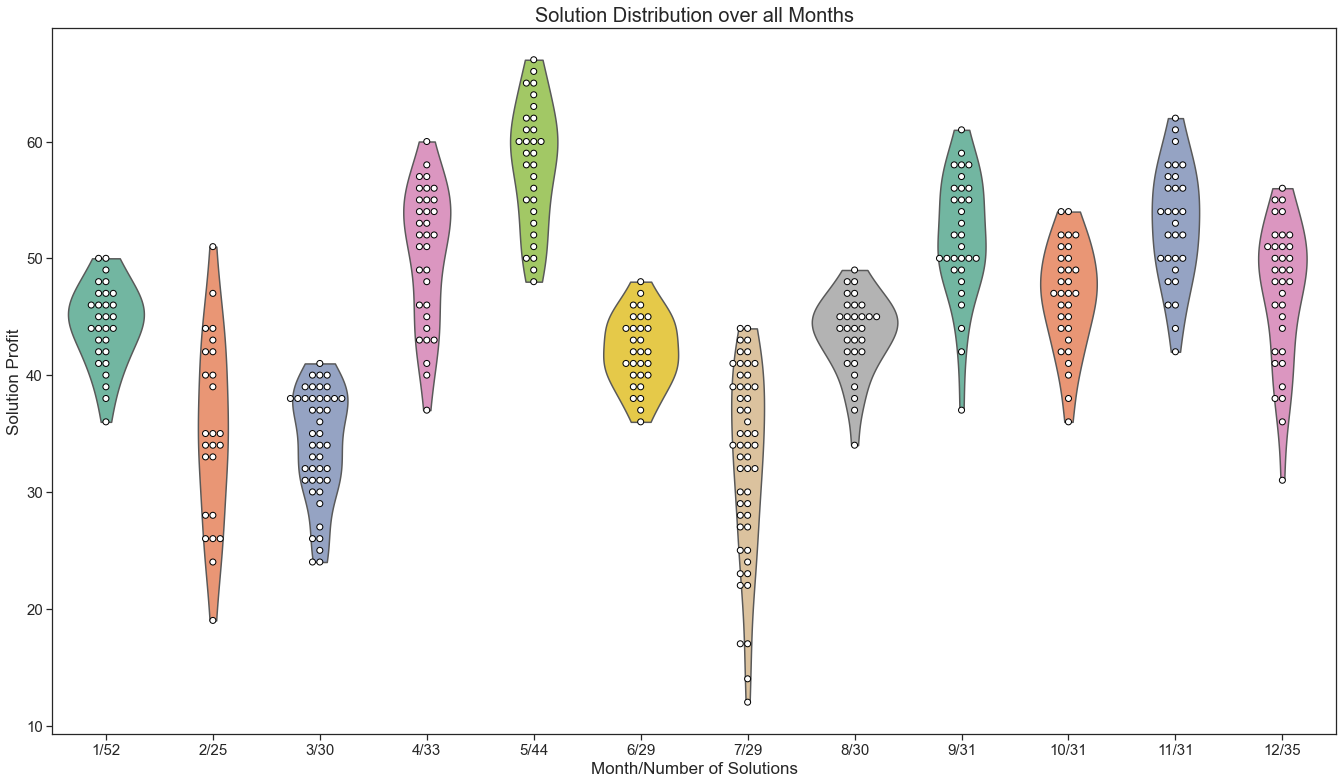

In [19]:

fig = plt.figure(figsize=(23, 13) )
sns.set_theme(style="ticks")
#sns.violinplot( y=df)
sns.violinplot( data = df,palette="Set2", cut = 0, inner = None)
sns.swarmplot( data = df, color = 'white', linewidth=1, size = 6, edgecolor="black")

plt.tick_params(axis='both', which='major', labelsize=15)
xticks = plt.xticks(np.arange(12), ('1/52', '2/25', '3/30', '4/33', '5/44', '6/29', '7/29','8/30','9/31','10/31','11/31','12/35'))
xlabel = plt.xlabel('Month/Number of Solutions', fontsize = 17)
ylabel = plt.ylabel('Solution Profit', fontsize = 17)
title = plt.title('Solution Distribution over all Months', fontsize = 20)
fig.savefig('Images/violin_solution_distr.jpg')


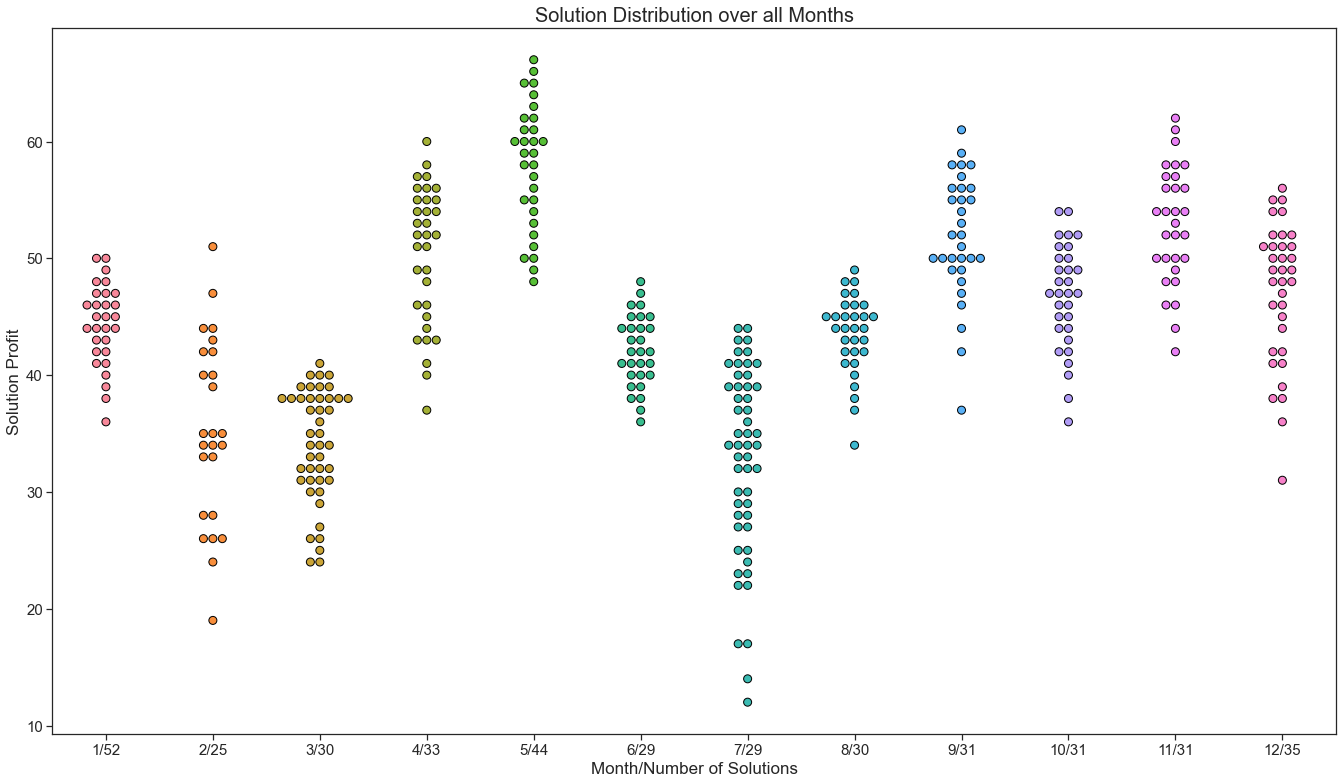

In [20]:


fig = plt.figure(figsize=(23, 13) )
sns.set_theme(style="ticks")
#sns.violinplot( y=df)
#sns.violinplot( data = df,palette="Set2", cut = 0, inner = None)
sns.swarmplot( data = df, linewidth=1, size = 8, edgecolor="black")

plt.tick_params(axis='both', which='major', labelsize=15)
xticks = plt.xticks(np.arange(12), ('1/52', '2/25', '3/30', '4/33', '5/44', '6/29', '7/29','8/30','9/31','10/31','11/31','12/35'))
xlabel = plt.xlabel('Month/Number of Solutions', fontsize = 17)
ylabel = plt.ylabel('Solution Profit', fontsize = 17)
title = plt.title('Solution Distribution over all Months', fontsize = 20)
fig.savefig('Images/swarm_solution_distr.jpg')


### Amount of paths for each profit value
Next we take a look at the amount of paths for each profit value. This could be an indicator as to how easily a solution is reached. Solutions which are available over a lot of paths should in theory be more accessible since going down the tree does not necessarily have a huge effect. However variability of solution (i.e. how many furniture items have to be considered) could also be a factor. Maybe this could be better represented by all solutions.

In [21]:
paths

Month,0,1,2,3,4,5,6,7,8,9,10,11
0,6.828712,4.430817,9.441452,11.616204,6.828712,6.828712,5.192957,8.055158,8.055158,8.055158,6.828712,5.347108
1,11.616204,0.000000,8.055158,11.146200,11.616204,11.616204,4.653960,6.828712,11.616204,6.828712,11.616204,9.536762
2,11.146200,2.995732,10.134599,7.832014,11.146200,11.146200,4.653960,10.134599,11.146200,10.134599,11.146200,8.438150
3,7.832014,6.445720,5.347108,9.536762,11.328522,7.832014,5.123964,11.616204,8.438150,11.616204,11.328522,7.745003
4,11.328522,2.302585,6.445720,11.328522,10.453053,11.328522,1.791759,11.146200,11.328522,11.146200,10.453053,8.620472
5,10.453053,6.222576,5.529429,8.438150,9.536762,10.453053,3.044522,9.441452,10.453053,9.441452,9.536762,8.930626
6,9.536762,5.529429,5.634790,10.453053,10.453053,9.536762,1.791759,8.438150,9.536762,11.328522,10.453053,7.927324
7,6.222576,6.040255,9.441452,9.536762,12.244812,6.222576,4.094345,11.328522,12.244812,9.536762,12.244812,5.347108
8,12.244812,5.347108,7.138867,12.244812,11.146200,12.244812,4.094345,9.536762,7.745003,12.244812,11.146200,5.347108
9,8.620472,5.817111,9.536762,7.745003,8.620472,8.620472,5.347108,12.244812,8.620472,5.634790,8.620472,6.222576


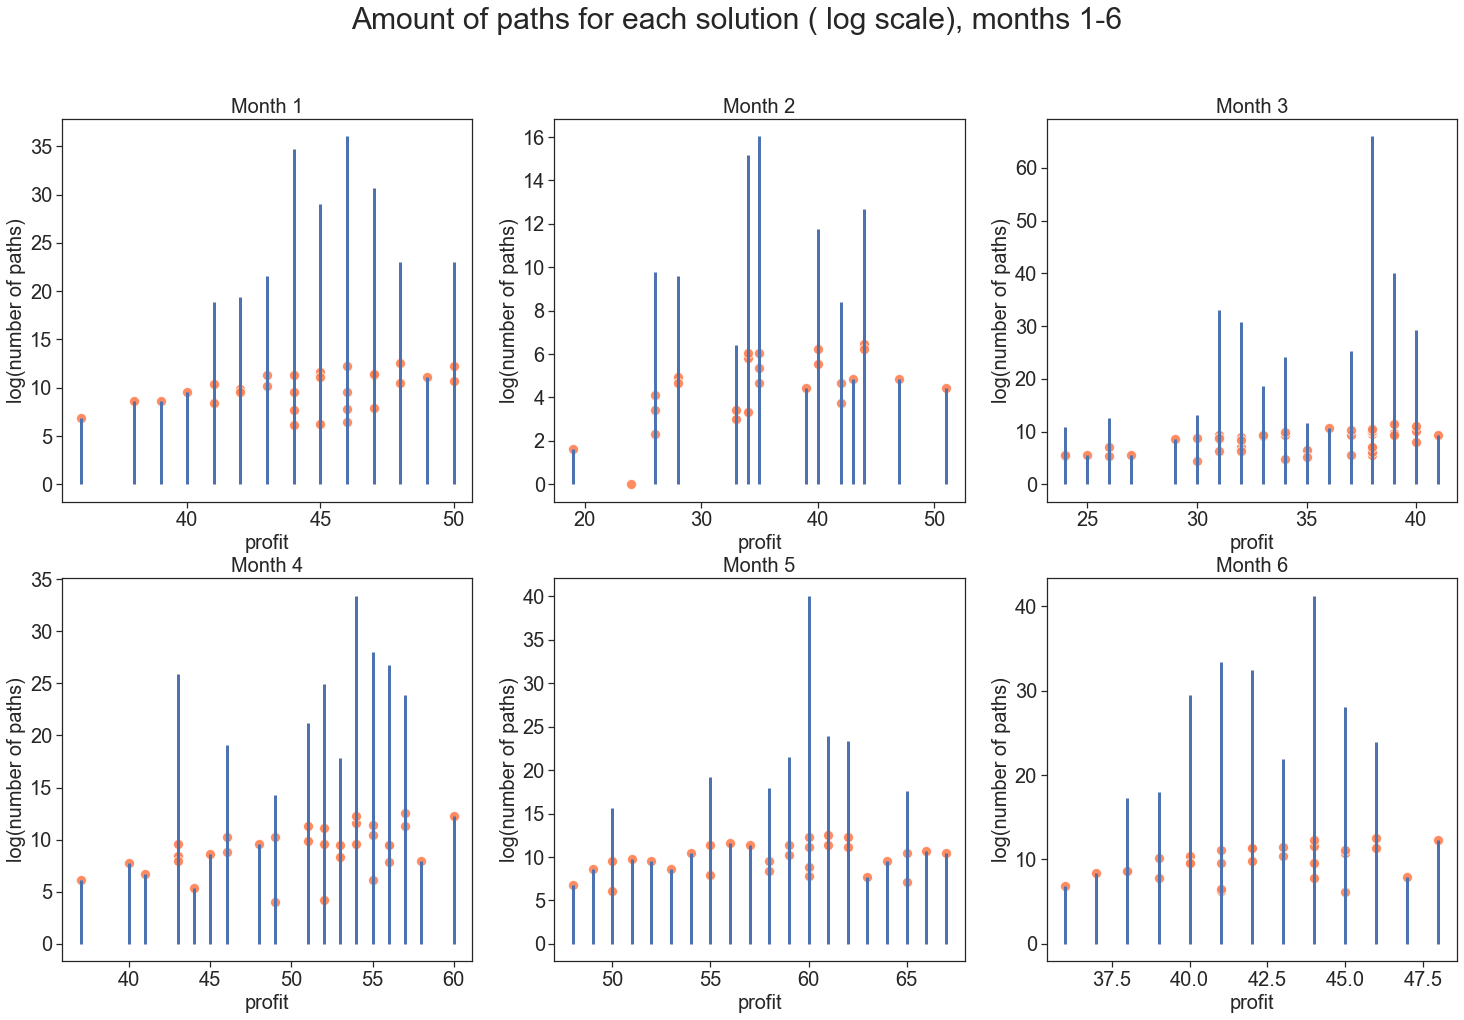

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(25, 15.5))
fig.suptitle('Amount of paths for each solution ( log scale), months 1-6', fontsize = 30)
c, j = 0,0
for i in range(6):
    df_new = pd.concat([df[i].rename('profit'),paths[i].rename('paths')], axis = 1 )
    dff =  df_new.groupby(['profit']).paths.sum().reset_index()

   #sns.barplot(ax = axes[c,j], x = dff['profit'],y = dff['paths'], linewidth=1, edgecolor="black")
    #plt.hlines(ax = axes[c,j],y=dff['paths'], xmin=0, xmax=dff['profit'], linewidth=3, alpha =0.8)
    axes[c,j].vlines(dff['profit'], ymin=0, ymax=dff['paths'], linewidth=3.0)
    #sns.scatterplot(ax = axes[c,j],x = dff['profit'],y = dff['paths'],  s=100, alpha=1)
    sns.scatterplot(ax = axes[c,j],x = df_new['profit'],y = df_new['paths']  ,s=100, alpha=0.9, color = 'coral')
    if j == 2:
        c+=1
        j=0
    else:
        j+=1

c = 0
for ax in axes.flat:
    #ax.set_xticklabels(keys)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    #ax.set_ylim([0,30])
    ax.set_title('Month {}'.format(c+1), fontsize = 20)
    ax.set_xlabel('profit', fontsize=20)
    ax.set_ylabel('log(number of paths)', fontsize=20)

    c +=1
plt.xlabel('profit')
fig.savefig('Images/paths_for_sol_0_5.jpg')

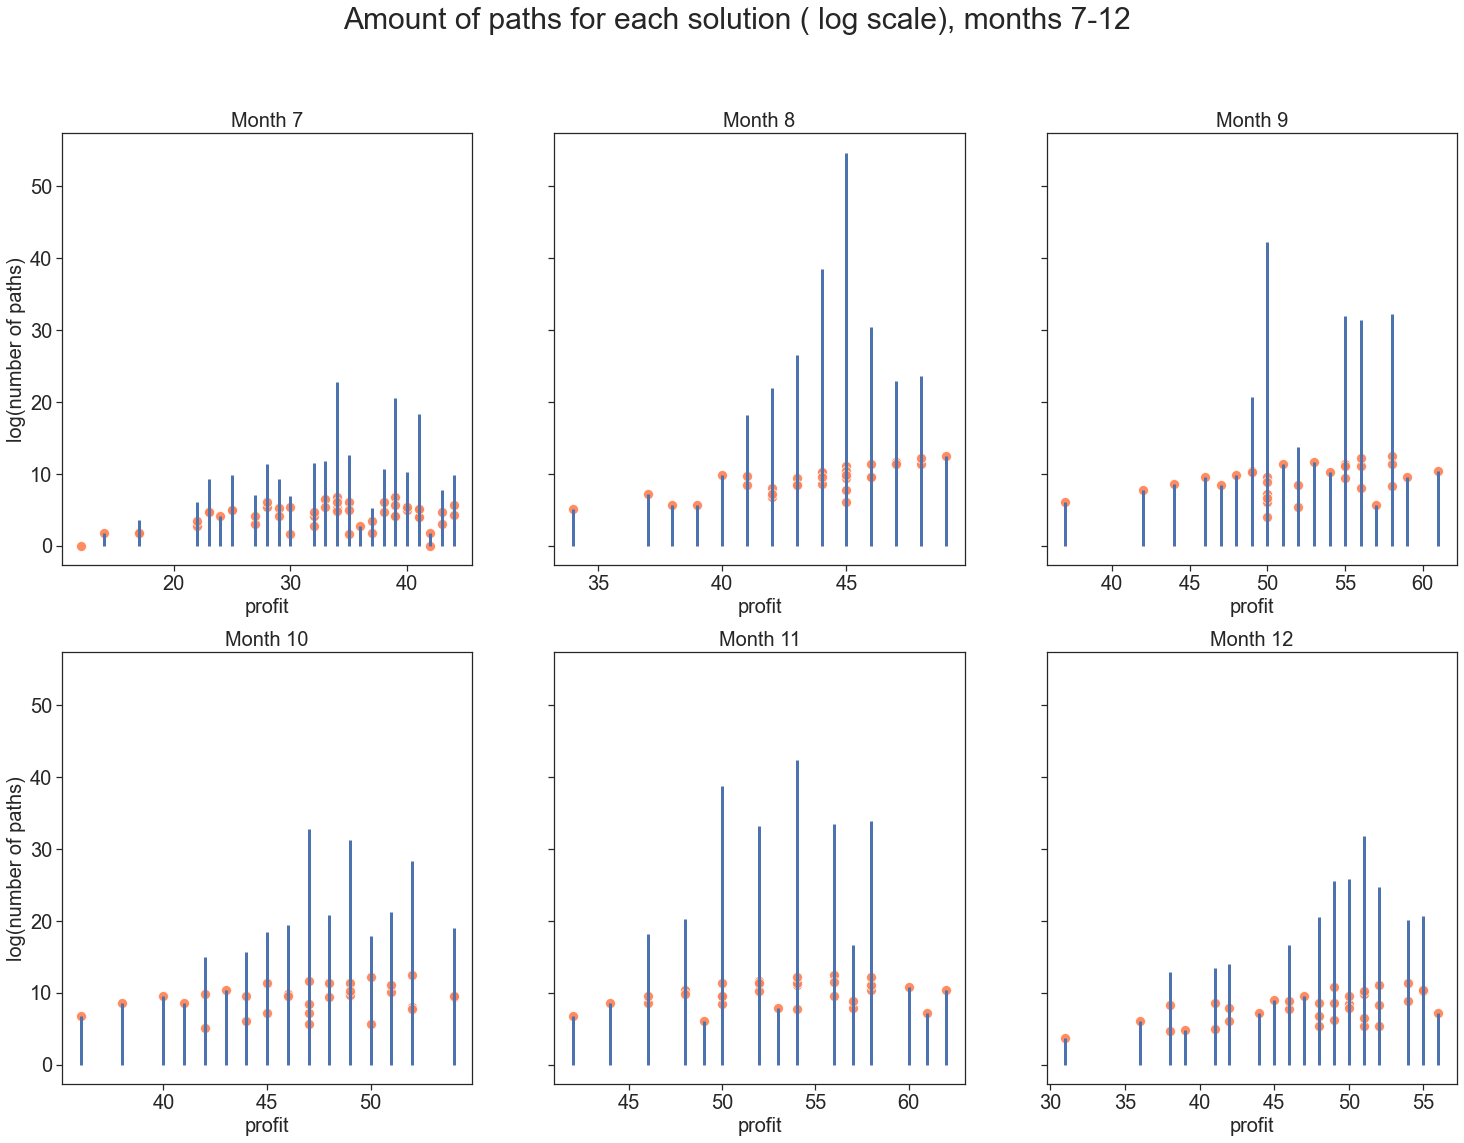

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(25, 17.5), sharey=True)
fig.suptitle('Amount of paths for each solution ( log scale), months 7-12', fontsize = 30)
c, j = 0,0
for i in range(6,12):

    df_new = pd.concat([df[i].rename('profit'),paths[i].rename('paths')], axis = 1 )
    dff =  df_new.groupby(['profit']).paths.sum().reset_index()

   #sns.barplot(ax = axes[c,j], x = dff['profit'],y = dff['paths'], linewidth=1, edgecolor="black")
    #plt.hlines(ax = axes[c,j],y=dff['paths'], xmin=0, xmax=dff['profit'], linewidth=3, alpha =0.8)
    axes[c,j].vlines(dff['profit'], ymin=0, ymax=dff['paths'], linewidth=3.0)
    #sns.scatterplot(ax = axes[c,j],x = dff['profit'],y = dff['paths'],  s=100, alpha=1)
    sns.scatterplot(ax = axes[c,j],x = df_new['profit'],y = df_new['paths'],  s=100, alpha=0.9, color = 'coral')

    if j == 2:
        c+=1
        j=0
    else:
        j+=1

c = 0
for ax in axes.flat:
    #ax.set_xticklabels(keys)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    #ax.set_ylim([0,30])
    ax.set_title('Month {}'.format(c+1+6), fontsize = 20)
    ax.set_xlabel('profit', fontsize=20)
    ax.set_ylabel('log(number of paths)', fontsize=20)

    c +=1
plt.xlabel('profit')
fig.savefig('Images/paths_for_sol_6_12.jpg')

## Variance in solution items


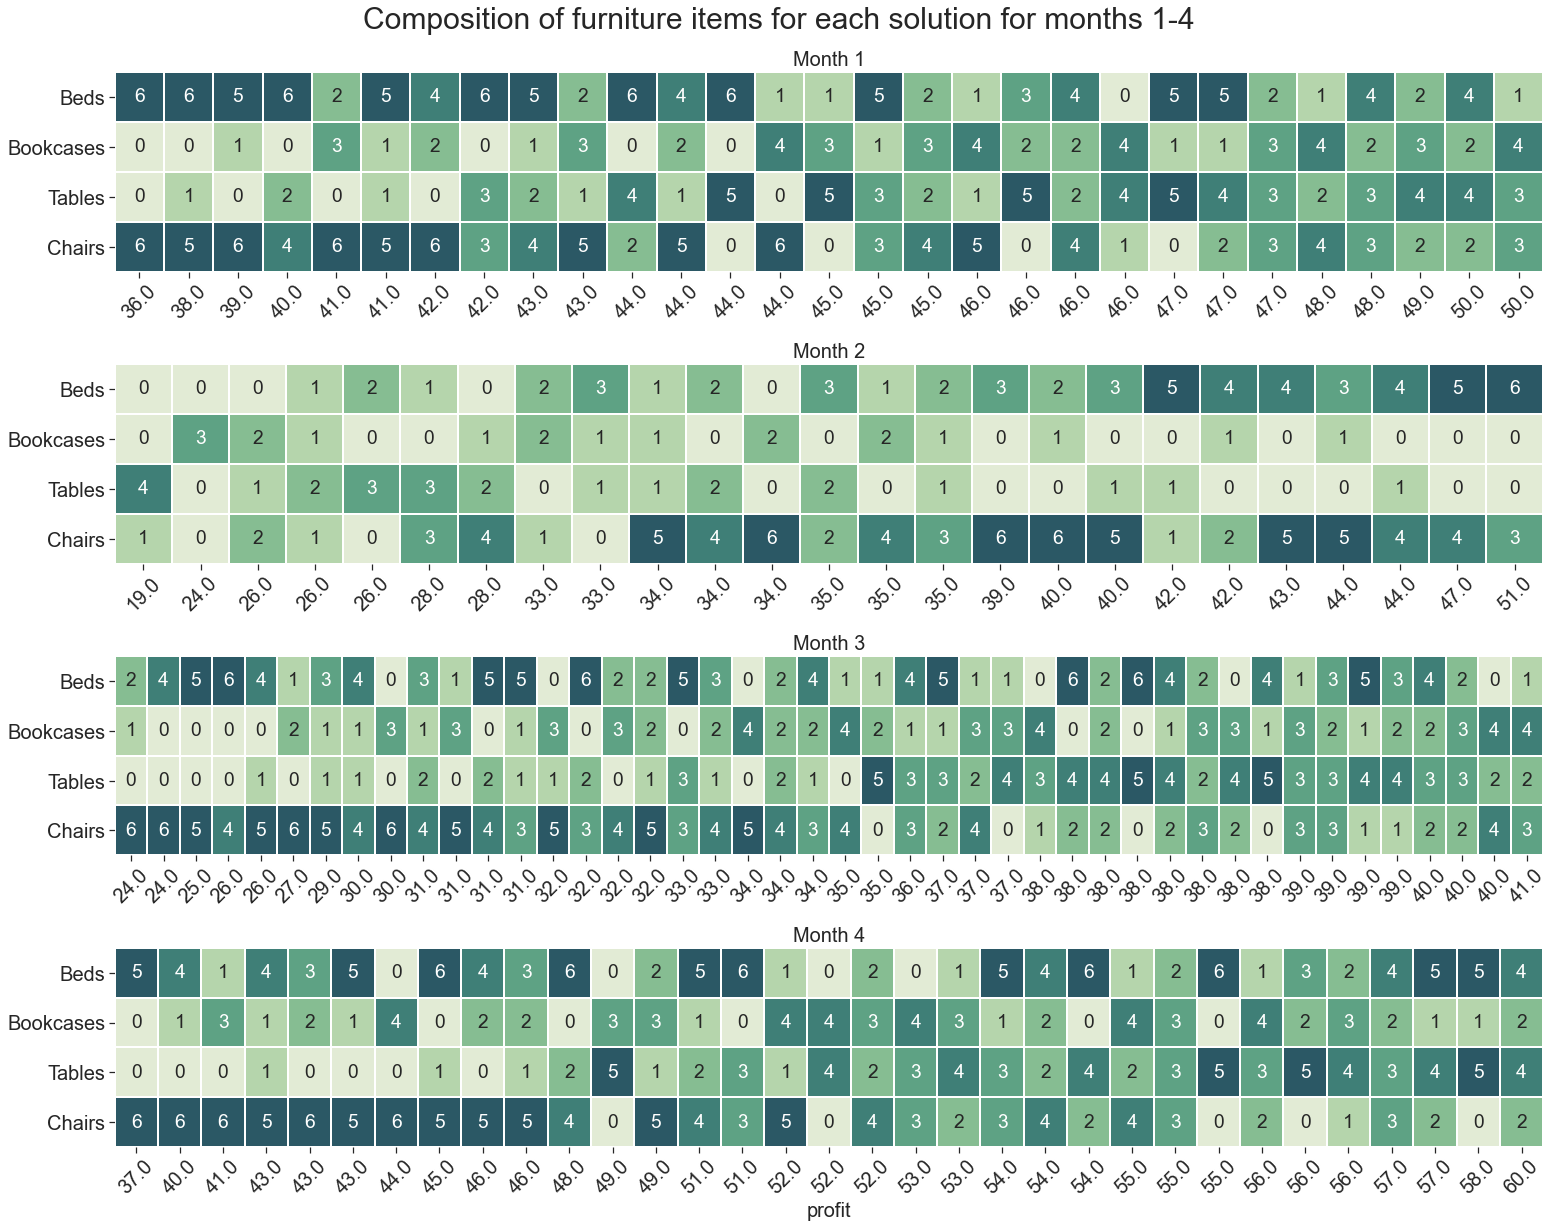

In [12]:
fig, axes = plt.subplots(4, 1, figsize=(22, 17.5))

colormap =  sns.cubehelix_palette(n_colors=6, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

fig.suptitle('Composition of furniture items for each solution for months 1-4', fontsize = 30)
c, j = 0,0
for i in range(4):
    leaves = np.array(leaves_all[i])
    data = [leaves[:,0],leaves[:,1],leaves[:,2],leaves[:,3]]
    df_furn = pd.DataFrame(data = data, index=['Beds','Bookcases','Tables','Chairs'])
    df_f = df_furn.transpose()
    df_new = pd.concat([df[i].rename('profit'),df_f], axis = 1 )
    df_new = df_new.sort_values(by ='profit' ).dropna()
    x_axis_labels = df_new['profit'] # labels for y-axis
    axes[i].set_title('Month {}'.format(i+1), fontsize = 20)
    sns.set(font_scale=1.6)
    if i == 3:
        sns.heatmap(ax = axes[i],
                    data = df_new[['Beds','Bookcases','Tables','Chairs']].transpose() ,
                    #cbar_kws = dict(use_gridspec=False,location="bottom"),
                    cbar = None,
                    cmap = colormap,
                    xticklabels=x_axis_labels,  annot = True, linewidths=1)
        axes[i].set_xlabel('profit', fontsize=20)
    else:
        sns.heatmap(ax = axes[i],
                    data = df_new[['Beds','Bookcases','Tables','Chairs']].transpose() ,
                    cbar = None,
                    cmap = colormap,
                    xticklabels=x_axis_labels,  
                    annot = True, linewidths=1)
        
for ax in axes:
    ax.tick_params(axis = 'y',labelrotation=0)
    ax.tick_params(axis = 'x',labelrotation=45)
    ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig('Images/furniture_composition_1_4.jpg')

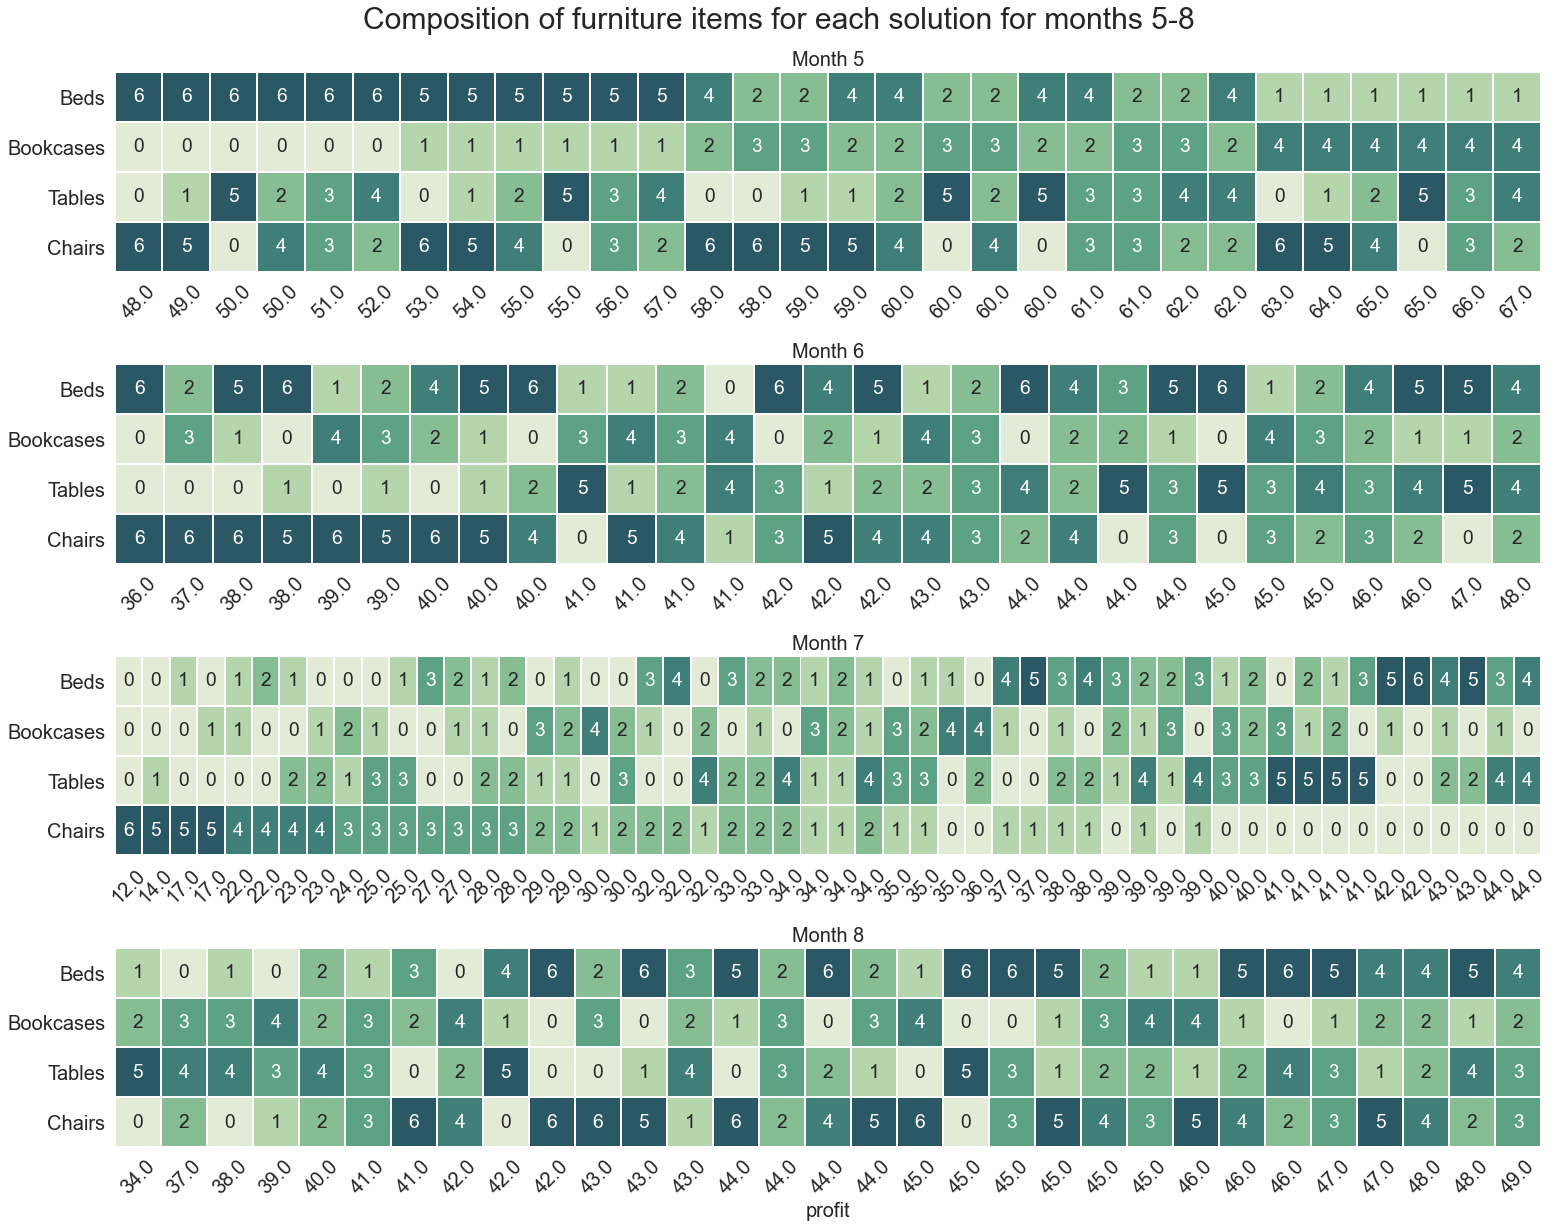

In [13]:
fig, axes = plt.subplots(4, 1, figsize=(22, 17.5))
colormap =  sns.cubehelix_palette(n_colors=6, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

fig.suptitle('Composition of furniture items for each solution for months 5-8', fontsize = 30)
c, j = 0,0
for i in range(4,8):
    leaves = np.array(leaves_all[i])
    data = [leaves[:,0],leaves[:,1],leaves[:,2],leaves[:,3]]
    df_furn = pd.DataFrame(data = data, index=['Beds','Bookcases','Tables','Chairs'])
    df_f = df_furn.transpose()
    df_new = pd.concat([df[i].rename('profit'),df_f], axis = 1 )
    df_new = df_new.sort_values(by ='profit' ).dropna()
    x_axis_labels = df_new['profit'] # labels for y-axis
    axes[j].set_title('Month {}'.format(i+1), fontsize = 20)
    sns.set(font_scale=1.6)

    sns.heatmap(ax = axes[j],
                data = df_new[['Beds','Bookcases','Tables','Chairs']].transpose() ,
                cbar = None,
                cmap = colormap,
                xticklabels=x_axis_labels,  
                annot = True, linewidths=1)
    if i == 7:
        axes[j].set_xlabel('profit', fontsize=20)

    j+=1
for ax in axes:
    ax.tick_params(axis = 'y',labelrotation=0)
    ax.tick_params(axis = 'x',labelrotation=45)
    ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig('Images/furniture_composition_5_8.jpg')

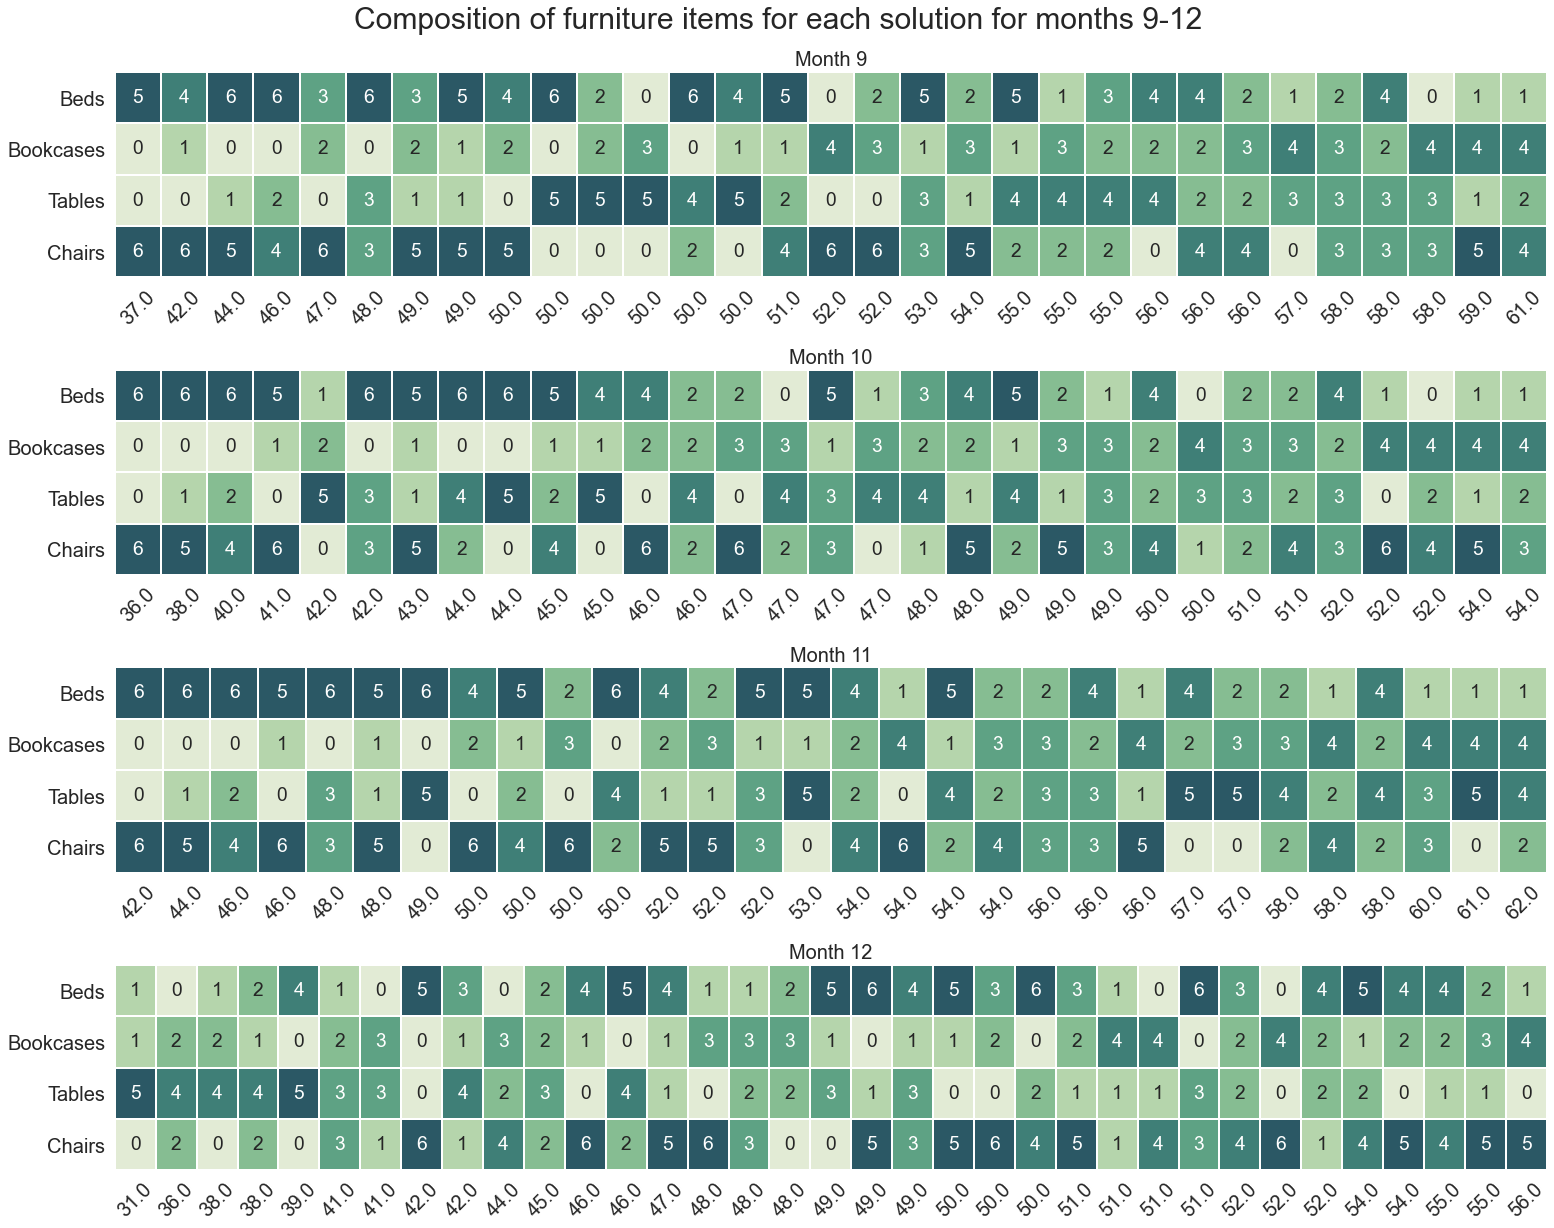

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(22, 17.5))
colormap =  sns.cubehelix_palette(n_colors=6, start=0, rot=-0.5, gamma=1.0, hue=0.8, light=0.9, dark=0.3)

fig.suptitle('Composition of furniture items for each solution for months 9-12', fontsize = 30)
c, j = 0,0
for i in range(8,12):
    leaves = np.array(leaves_all[i])
    data = [leaves[:,0],leaves[:,1],leaves[:,2],leaves[:,3]]
    df_furn = pd.DataFrame(data = data, index=['Beds','Bookcases','Tables','Chairs'])
    df_f = df_furn.transpose()
    df_new = pd.concat([df[i].rename('profit'),df_f], axis = 1 )
    df_new = df_new.sort_values(by ='profit' ).dropna()
    x_axis_labels = df_new['profit'] # labels for y-axis
    axes[j].set_title('Month {}'.format(i+1), fontsize = 20)
    sns.set(font_scale=1.6)

    sns.heatmap(ax = axes[j],
                data = df_new[['Beds','Bookcases','Tables','Chairs']].transpose() ,
                cbar = None,
                cmap = colormap,
                xticklabels=x_axis_labels,  
                annot = True, linewidths=1)
    if i == 7:
        axes[j].set_xlabel('profit', fontsize=20)

    j+=1
for ax in axes:
    ax.tick_params(axis = 'y',labelrotation=0)
    ax.tick_params(axis = 'x',labelrotation=45)
    ax.tick_params(axis='both', which='major', labelsize=20)
fig.tight_layout()
fig.savefig('Images/furniture_composition_9_12.jpg')

In [15]:
my_palette = sns.choose_cubehelix_palette()

interactive(children=(IntSlider(value=9, description='n_colors', max=16, min=2), FloatSlider(value=0.0, descri…

In [16]:
par_parent_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_file = 'data/online/full_experiment/data_furnituremanufacturing_2021-08-11_09-15.csv'
data_path = os.path.join(par_parent_dir, data_file)
m = 8
# transform to dataframe
df, df_model, df_ge, df_vp_sol, df_qual,  df_actions, df_built, df_resources, df_play_times = decompose_csv(data_path)
df_complete_sol =  get_complete_sol(df_resources)


df_furn = get_furniture_dict(df_vp_sol, df_complete_sol)
df_profit, df_paths, df_leaves = generate_feasible_solutions(df_furn)
df_leaves.loc[df_leaves.month == m, ["solutions","profit","Number of solutions"]]


NameError: name 'decompose_csv' is not defined